## Chronos_AllCovs


In [2]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

## Monthly

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['dI_t', 'VIX', 'Q', 'SP500', 'OBX_Energy', 'EUR_NOK', 'OSEBX', 'd_pi', 'Brent', 'StoxEurope']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – past covariates) ===
Observations: 308
RMSE (level): 0.141516
MAE  (level): 0.096316
Directional accuracy: 208/307 (67.8%)

=== Diebold–Mariano vs Random Walk (past covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.5571
p-value     : 0.0106

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped mon

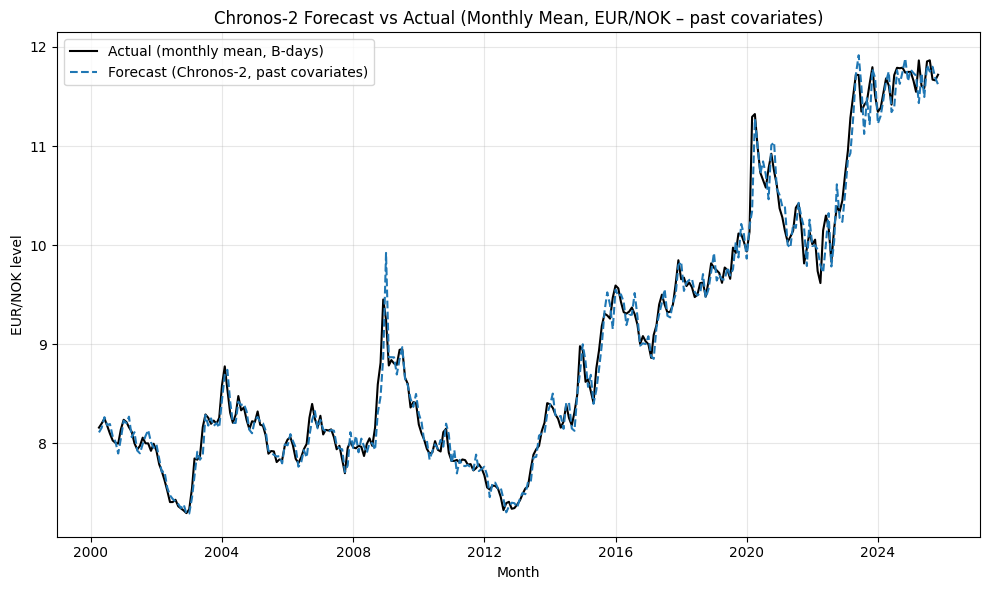

Saved: Chronos2M_daily_pastcov.png
Saved: Chronos2M_daily_pastcov.pdf


In [5]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - Exogenous: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy + macro cols
              passed as past-only covariates in context_df
  - Cut: last business day of previous month (EUR_NOK B-days)
  - Forecast: next calendar month daily -> aggregated to monthly B-day mean

Added:
  - DM p-value importance via leave-one-out covariate removal.
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 40          # Minimum history length before forecasting
    max_context: int = 2048          # Chronos max context window
    max_horizon: int = 64            # Safety cap for forecast horizon (days)
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_pastcov.png"
    fig_pdf: str = "Chronos2M_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Exogenous daily financial covariates
EXOG_COLS = [
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]

# Macro covariates (assumed daily aligned / ffilled)
MACRO_COLS = ["Q", "d_pi", "dI_t"]

ALL_COV_COLS = EXOG_COLS + MACRO_COLS

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retries."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill
      DF_d : daily (D) wide DataFrame with TARGET + covariates (calendar days), ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {
        "Date", "EUR_NOK", "Q", "d_pi", "dI_t",
        "Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"
    }
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["EUR_NOK"])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar days) with ffill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Find the last business-day timestamp in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Build SINGLE-SERIES context_df with selectable past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <cov_cols>]
    Single item only (EUR_NOK). Covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create a Chronos-2 forecasting function that uses past-only covariates."""

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to a standard (item_id, timestamp, y_pred) schema."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """
        Forecast H days ahead using past-only covariates in context_df.
        Note: future_df is NOT passed => covariates are treated as past-only.
        """
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # disable cross-learning explicitly
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward (monthly, past-only covariates)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    """
    For each month:
      1) Cut history at last business day of previous month
      2) Forecast daily for next month (calendar days)
      3) Aggregate forecast to monthly mean over business days
    """

    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        # Forecast horizon in calendar days
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        # Build context with selected covariates
        context_df = make_pastcov_context(hist_wide, cov_cols)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        # Create calendar-day forecast index starting after cut
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        # Extract target series forecasts
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy()
        df_fx = df_fx.sort_values("timestamp")

        # Align predictions to daily index and forward-fill gaps
        pred_daily = pd.Series(index=f_idx, dtype=float, name="point")
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        # Aggregate to monthly business-day mean
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df

# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    """Compute RMSE/MAE and directional accuracy for monthly means."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (monthly mean, EUR/NOK – past covariates) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

def _normal_cdf(z: float) -> float:
    """Standard normal CDF via erf."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """
    Diebold–Mariano test for equal predictive accuracy against random walk.
    Returns (dm_stat, p_val).
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    # Newey–West correction for multi-step horizons
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Convenience wrapper to print DM test vs RW."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (past covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val

def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot baseline monthly actual vs forecast and save to disk."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, past covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – past covariates)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# DM p-value importance (leave-one-out)
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
    silent_eval: bool = True,
) -> Tuple[float, float]:
    """
    Run full walk-forward for a given covariate set and return DM-stat and p-value.
    """
    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn, cov_cols)
    ev = evaluate(df_eval, silent=silent_eval)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val

def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """
    Leave-one-out importance:
      - Baseline DM p-value with all covariates
      - For each covariate: remove it, re-run, compute p_without
      - delta_p = p_without - p_baseline
    Larger delta_p => covariate contributes more to lowering p.
    """
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, cov_cols)

    rows = []
    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, reduced)

        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,   # increase in p when covariate is removed
            "dm_without": stat_i
        })

    out = (
        pd.DataFrame(rows)
        .sort_values("delta_p", ascending=False)
        .reset_index(drop=True)
    )
    return base_stat, base_p, out

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    # Baseline with all covariates
    df_eval_base = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn, ALL_COV_COLS)
    eval_df_base = evaluate(df_eval_base, silent=False)

    base_stat, base_p = dm_against_random_walk(eval_df_base, loss="mse", h=1)

    # Leave-one-out DM p-value importance
    base_stat2, base_p2, p_imp = pvalue_importance_leave_one_out(
        S_b, DF_d, forecast_fn, ALL_COV_COLS
    )

    print("\n=== DM p-value importance (leave-one-out) ===")
    print(f"Baseline DM-stat: {base_stat2:.4f} | p={base_p2:.4f}\n")
    print(p_imp.to_string(index=False))

    # Plot baseline forecast vs actual
    plot_monthly_simple(eval_df_base, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


Important covariates (round 1): ['dI_t', 'VIX', 'OSEBX', 'OBX_Energy', 'd_pi', 'SP500', 'StoxEurope']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['dI_t', 'VIX', 'OBX_Energy', 'SP500', 'EUR_NOK', 'OSEBX', 'd_pi', 'StoxEurope']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – important covariates) ===
Observations: 308
RMSE (level): 0.140551
MAE  (level): 0.095761
Directional accuracy: 210/307 (68.4%)

=== Diebold–Mariano vs Random Walk (monthly | important covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.5936
p-value     : 0.0095

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dr

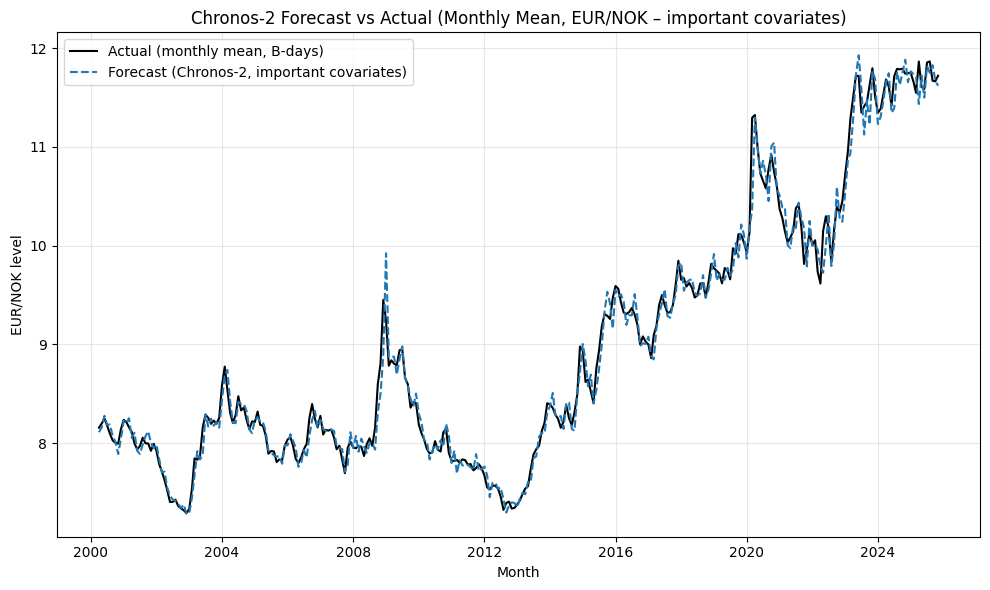

Saved: Chronos2M_daily_round2_important.png
Saved: Chronos2M_daily_round2_important.pdf


In [15]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning).

ROUND 2 (monthly):
  - Use IMPORTANT_COV_R1 based on round-1 leave-one-out (delta_p > 0).
  - Run baseline monthly walk-forward.
  - Compute DM vs Random Walk.
  - Re-run leave-one-out on IMPORTANT_COV_R1 to see who still matters.
  - Suggest IMPORTANT_COV_R2 as delta_p > 0 within this round.

Important covariates from your round-1 output (delta_p>0):
  ['dI_t','VIX','OSEBX','OBX_Energy','d_pi','SP500','StoxEurope']
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_round2_important.png"
    fig_pdf: str = "Chronos2M_daily_round2_important.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# IMPORTANT covariates from round 1 (delta_p > 0)
IMPORTANT_COV_R1 = ["dI_t", "VIX", "OSEBX", "OBX_Energy", "d_pi", "SP500", "StoxEurope"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retries."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (only pulls needed cols)
# -----------------------------
def load_series(url: str, cov_cols: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill
      DF_d : daily (D) wide DataFrame with TARGET + cov_cols (calendar days), ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(cov_cols)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar days) with ffill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Find the last business-day timestamp in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Build SINGLE-SERIES context_df with selectable past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <cov_cols>]
    Single item only (EUR_NOK). Covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")


# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create a Chronos-2 forecasting function that uses past-only covariates."""
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """Forecast H days ahead using past-only covariates."""
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,
            )
        return _extract_median(pred)

    return _forecast


# -----------------------------
# Walk-forward (monthly, past-only covariates)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    """Monthly walk-forward with daily horizon and B-day monthly mean aggregation."""
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide, cov_cols)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df


# -----------------------------
# Evaluation / DM
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    """Compute RMSE/MAE and directional accuracy for monthly means."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (monthly mean, EUR/NOK – important covariates) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    """Standard normal CDF via erf."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test vs random walk."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Random walk benchmark uses previous month's observed level."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (monthly | important covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


# -----------------------------
# Leave-one-out importance
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[float, float]:
    """Run monthly walk-forward for cov_cols and return DM stat + p-value."""
    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn, cov_cols)
    ev = evaluate(df_eval, silent=True)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val


def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """
    Leave-one-out importance on cov_cols.
    delta_p = p_without - p_baseline.
    """
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, cov_cols)

    rows = []
    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, reduced)
        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,
            "dm_without": stat_i
        })

    out = pd.DataFrame(rows).sort_values("delta_p", ascending=False).reset_index(drop=True)
    return base_stat, base_p, out


# -----------------------------
# Plot
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot actual vs forecast for the monthly mean."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, important covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – important covariates)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main (ROUND 2)
# -----------------------------
def main():
    # Load only important covariates to avoid KeyError
    S_b, DF_d = load_series(CFG.url, IMPORTANT_COV_R1)

    if CFG.verbose:
        print(f"Important covariates (round 1): {IMPORTANT_COV_R1}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    # Baseline on important set
    df_eval_base = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn, IMPORTANT_COV_R1)
    eval_df_base = evaluate(df_eval_base, silent=False)

    dm_stat_base, dm_p_base = dm_against_random_walk(eval_df_base, loss="mse", h=1)

    # Leave-one-out on important set
    base_stat2, base_p2, p_imp = pvalue_importance_leave_one_out(
        S_b, DF_d, forecast_fn, IMPORTANT_COV_R1
    )

    print("\n=== DM p-value importance (leave-one-out, monthly | round 2 on important set) ===")
    print(f"Baseline DM-stat: {base_stat2:.4f} | p={base_p2:.4f}\n")
    print(p_imp.to_string(index=False))

    important_r2 = p_imp.loc[p_imp["delta_p"] > 0, "covariate"].tolist()
    print(f"\nSuggested important covariates (round 3, delta_p>0): {important_r2}")

    plot_monthly_simple(eval_df_base, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()


Important covariates (round 3 input): ['VIX', 'dI_t', 'OBX_Energy', 'OSEBX', 'StoxEurope', 'SP500']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['dI_t', 'VIX', 'OBX_Energy', 'SP500', 'EUR_NOK', 'OSEBX', 'StoxEurope']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – important covariates) ===
Observations: 308
RMSE (level): 0.140493
MAE  (level): 0.095548
Directional accuracy: 211/307 (68.7%)

=== Diebold–Mariano vs Random Walk (monthly | important covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.6197
p-value     : 0.0088

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped mont

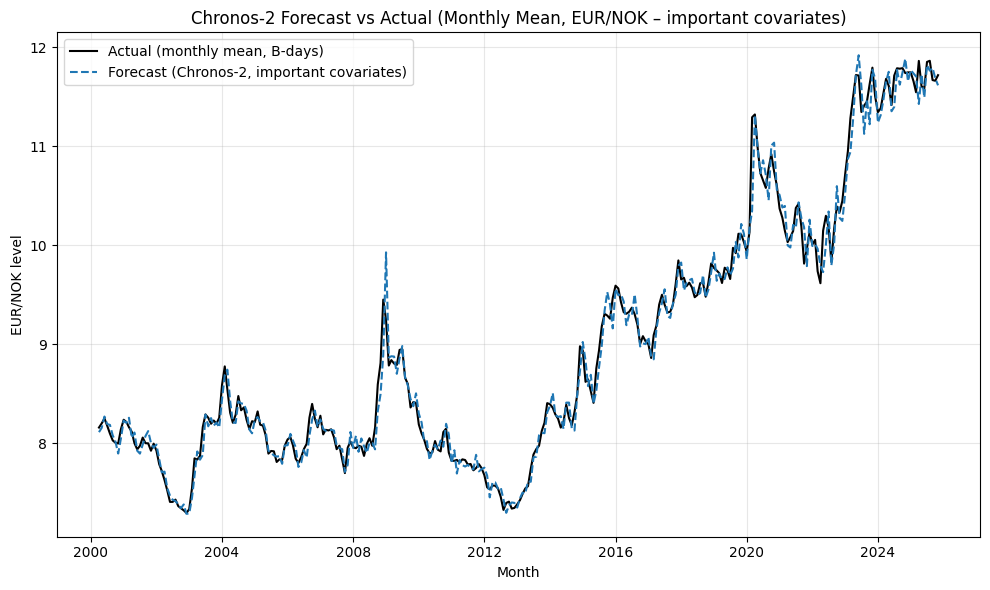

Saved: Chronos2M_daily_round3_important.png
Saved: Chronos2M_daily_round3_important.pdf


In [16]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning).

ROUND 3 (monthly):
  - Input covariates = suggested important set from round 2 (delta_p > 0)
  - Run baseline monthly walk-forward.
  - Compute DM vs Random Walk.
  - Run leave-one-out on this reduced set.
  - Suggest next-round covariates as delta_p > 0.

Round 2 suggested important covariates:
  ['VIX', 'dI_t', 'OBX_Energy', 'OSEBX', 'StoxEurope', 'SP500']
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_round3_important.png"
    fig_pdf: str = "Chronos2M_daily_round3_important.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Round-3 input covariates (from round 2 suggestion)
IMPORTANT_COV_R3_INPUT = ["VIX", "dI_t", "OBX_Energy", "OSEBX", "StoxEurope", "SP500"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retries."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (only pulls needed cols)
# -----------------------------
def load_series(url: str, cov_cols: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill
      DF_d : daily (D) wide DataFrame with TARGET + cov_cols (calendar days), ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(cov_cols)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar days) with ffill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Find the last business-day timestamp in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Build SINGLE-SERIES context_df with selectable past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <cov_cols>]
    Single item only (EUR_NOK). Covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")


# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create a Chronos-2 forecasting function that uses past-only covariates."""
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """Forecast H days ahead using past-only covariates."""
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,
            )
        return _extract_median(pred)

    return _forecast


# -----------------------------
# Walk-forward (monthly, past-only covariates)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    """Monthly walk-forward with daily horizon and B-day monthly mean aggregation."""
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide, cov_cols)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df


# -----------------------------
# Evaluation / DM
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    """Compute RMSE/MAE and directional accuracy for monthly means."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (monthly mean, EUR/NOK – important covariates) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    """Standard normal CDF via erf."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test vs random walk."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Random walk benchmark uses previous month's observed level."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (monthly | important covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


# -----------------------------
# Leave-one-out importance
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[float, float]:
    """Run monthly walk-forward for cov_cols and return DM stat + p-value."""
    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn, cov_cols)
    ev = evaluate(df_eval, silent=True)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val


def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """Leave-one-out importance on cov_cols."""
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, cov_cols)

    rows = []
    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, reduced)
        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,
            "dm_without": stat_i
        })

    out = pd.DataFrame(rows).sort_values("delta_p", ascending=False).reset_index(drop=True)
    return base_stat, base_p, out


# -----------------------------
# Plot
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot actual vs forecast for the monthly mean."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, important covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – important covariates)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main (ROUND 3)
# -----------------------------
def main():
    # Load only round-3 covariates to avoid KeyError
    S_b, DF_d = load_series(CFG.url, IMPORTANT_COV_R3_INPUT)

    if CFG.verbose:
        print(f"Important covariates (round 3 input): {IMPORTANT_COV_R3_INPUT}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    # Baseline on round-3 set
    df_eval_base = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn, IMPORTANT_COV_R3_INPUT)
    eval_df_base = evaluate(df_eval_base, silent=False)

    dm_stat_base, dm_p_base = dm_against_random_walk(eval_df_base, loss="mse", h=1)

    # Leave-one-out on round-3 set
    base_stat2, base_p2, p_imp = pvalue_importance_leave_one_out(
        S_b, DF_d, forecast_fn, IMPORTANT_COV_R3_INPUT
    )

    print("\n=== DM p-value importance (leave-one-out, monthly | round 3 on important set) ===")
    print(f"Baseline DM-stat: {base_stat2:.4f} | p={base_p2:.4f}\n")
    print(p_imp.to_string(index=False))

    important_r4 = p_imp.loc[p_imp["delta_p"] > 0, "covariate"].tolist()
    print(f"\nSuggested important covariates (round 4, delta_p>0): {important_r4}")

    plot_monthly_simple(eval_df_base, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()


Selected covariates: ['VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy', 'd_pi', 'dI_t']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['dI_t', 'VIX', 'SP500', 'OBX_Energy', 'EUR_NOK', 'OSEBX', 'd_pi', 'StoxEurope']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – important covariates) ===
Observations: 308
RMSE (level): 0.140551
MAE  (level): 0.095761
Directional accuracy: 210/307 (68.4%)

=== Diebold–Mariano vs Random Walk (important covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.5936
p-value     : 0.0095


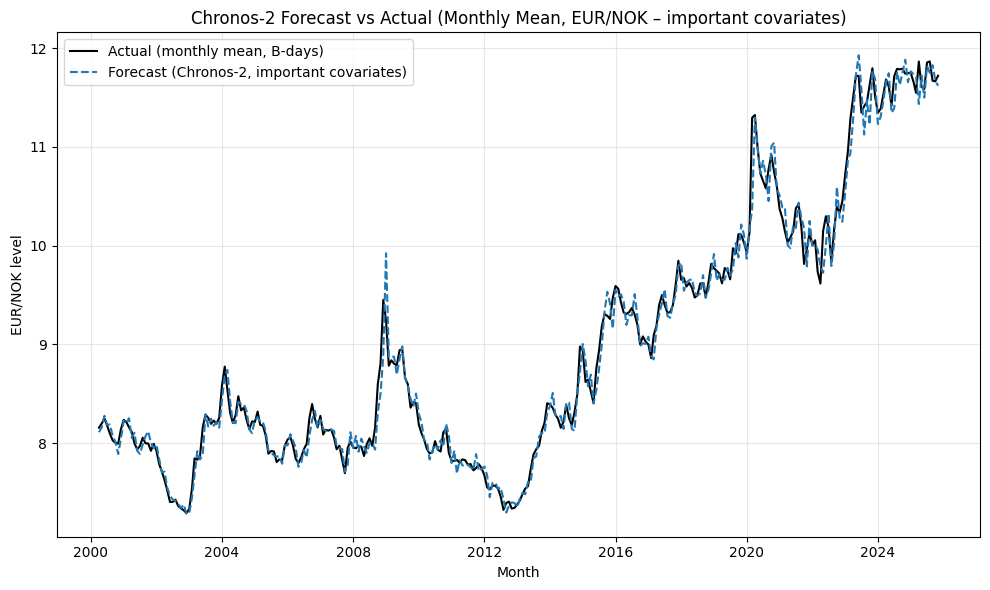

Saved: Chronos2M_daily_importantcov.png
Saved: Chronos2M_daily_importantcov.pdf


In [8]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - Covariates: only those that reduced DM p-value the most (delta_p > 0)
  - Cut: last business day of previous month (EUR_NOK B-days)
  - Forecast: next calendar month daily -> aggregated to monthly B-day mean
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_importantcov.png"
    fig_pdf: str = "Chronos2M_daily_importantcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Covariates kept because they reduce DM p-value (delta_p > 0)
EXOG_COLS = [
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["d_pi", "dI_t"]  # Q removed, d_pi and dI_t kept

ALL_COV_COLS = EXOG_COLS + MACRO_COLS

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retry logic."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with ffill
      DF_d : daily (D) wide DataFrame with TARGET + selected covariates (calendar days, ffill)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(ALL_COV_COLS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar daily index) with forward fill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Build SINGLE-SERIES context_df with past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <ALL_COV_COLS>]
    One item only (EUR_NOK). Selected covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in ALL_COV_COLS:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create Chronos-2 forecasting function for past-only covariates."""

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """
        Forecast H days ahead using past-only covariates in context_df.
        future_df is NOT passed => covariates are past-only.
        """
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # disable cross-learning explicitly
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward (monthly)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    """Monthly walk-forward with daily horizon and monthly B-day mean aggregation."""

    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df

# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Print monthly RMSE/MAE and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – important covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

def _normal_cdf(z: float) -> float:
    """Standard normal CDF."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test vs random walk."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Print DM-test results against RW."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (important covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot monthly actual vs forecast."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, important covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – important covariates)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Selected covariates: {ALL_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)

    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


## Quarterly


Important covariates (monthly round 3): ['VIX', 'dI_t', 'OBX_Energy', 'OSEBX', 'StoxEurope', 'SP500']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['dI_t', 'VIX', 'OBX_Energy', 'SP500', 'EUR_NOK', 'OSEBX', 'StoxEurope']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – important covariates round 3) ===
Observations: 308
RMSE (level): 0.140493
MAE  (level): 0.095548
Directional accuracy: 211/307 (68.7%)

=== Diebold–Mariano vs Random Walk (important covariates round 3) ===
Loss: MSE | horizon h=1
DM-statistic: -2.6197
p-value     : 0.0088


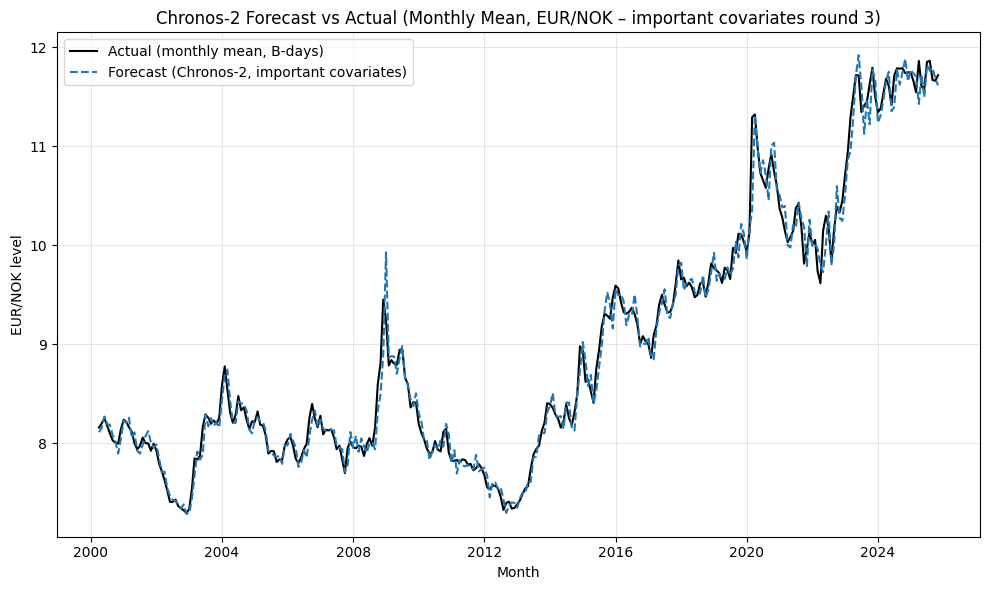

Saved: Chronos2M_daily_importantcov_round3.png
Saved: Chronos2M_daily_importantcov_round3.pdf


In [17]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily important covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - Covariates: important set from leave-one-out DM p-value rounds
      Important covariates (round 3):
        ['VIX', 'dI_t', 'OBX_Energy', 'OSEBX', 'StoxEurope', 'SP500']
  - Cut: last business day of previous month (EUR_NOK B-days)
  - Forecast: next calendar month daily -> aggregated to monthly B-day mean
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_importantcov_round3.png"
    fig_pdf: str = "Chronos2M_daily_importantcov_round3.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Important covariates from monthly leave-one-out round 3
IMPORTANT_COV_COLS: List[str] = [
    "VIX",
    "dI_t",
    "OBX_Energy",
    "OSEBX",
    "StoxEurope",
    "SP500",
]

ALL_COV_COLS = IMPORTANT_COV_COLS

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retry logic."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with ffill
      DF_d : daily (D) wide DataFrame with TARGET + selected covariates (calendar days, ffill)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(ALL_COV_COLS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar daily index) with forward fill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Build SINGLE-SERIES context_df with past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <ALL_COV_COLS>]
    One item only (EUR_NOK). Selected covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in ALL_COV_COLS:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create Chronos-2 forecasting function for past-only covariates."""

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """
        Forecast H days ahead using past-only covariates in context_df.
        future_df is NOT passed => covariates are past-only.
        """
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # disable cross-learning explicitly
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward (monthly)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    """Monthly walk-forward with daily horizon and monthly B-day mean aggregation."""

    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df

# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Print monthly RMSE/MAE and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – important covariates round 3) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

def _normal_cdf(z: float) -> float:
    """Standard normal CDF."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test vs random walk."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Print DM-test results against RW."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (important covariates round 3) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot monthly actual vs forecast."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, important covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – important covariates round 3)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Important covariates (monthly round 3): {ALL_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)

    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


Important covariates: ['VIX', 'SP500', 'd_pi', 'Q']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['Q', 'SP500', 'EUR_NOK', 'd_pi', 'VIX']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – important covariates) ===
Observations: 103
RMSE (level): 0.202085
MAE  (level): 0.141904
Directional accuracy: 78/102 (76.5%)

=== Diebold–Mariano vs Random Walk (important covariates, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -1.5752
p-value     : 0.1152


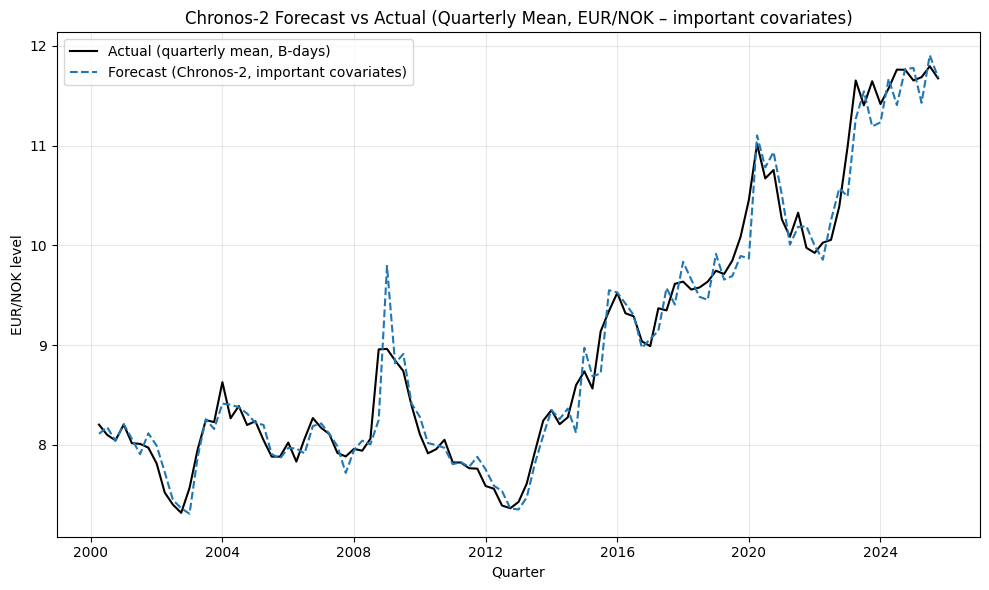

Saved: Chronos2Q_daily_importantcov.png
Saved: Chronos2Q_daily_importantcov.pdf


In [10]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - Covariates: only quarterly-important covariates (delta_p > 0 from LOO DM test)
      IMPORTANT EXOG: VIX, SP500
      IMPORTANT MACRO: d_pi, Q
  - Cut: last business day of previous quarter (EUR_NOK B-days)
  - Forecast: next calendar quarter daily -> aggregated to quarterly B-day mean
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"      # calendar quarterly evaluation
    min_hist_days: int = 40    # minimum daily history before first forecast
    max_context: int = 2048
    max_horizon: int = 128     # safe cap > max quarter length (~92 days)
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_importantcov.png"
    fig_pdf: str = "Chronos2Q_daily_importantcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# IMPORTANT covariates from quarterly LOO (delta_p > 0)
IMPORTANT_EXOG_COLS = ["VIX", "SP500"]
IMPORTANT_MACRO_COLS = ["d_pi", "Q"]

ALL_COV_COLS = IMPORTANT_EXOG_COLS + IMPORTANT_MACRO_COLS

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retries."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill
      DF_d : daily (D) wide DataFrame with TARGET + IMPORTANT covariates (calendar days), ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(ALL_COV_COLS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar days) with forward fill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Find the last business-day timestamp in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Build SINGLE-SERIES context_df with past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <ALL_COV_COLS>]
    Single item only (EUR_NOK). Covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in ALL_COV_COLS:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create Chronos-2 forecasting function that uses past-only covariates."""

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """
        Forecast H days ahead using past-only covariates in context_df.
        future_df is NOT passed => covariates are treated as past-only.
        """
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # explicitly disable cross-learning
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward (quarterly, past-only covariates)
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    """
    For each quarter:
      1) Cut history at last business day of previous quarter
      2) Forecast daily for next quarter (calendar days)
      3) Aggregate forecast to quarterly mean over business days
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df

# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute RMSE/MAE and directional accuracy for quarterly means."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – important covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

def _normal_cdf(z: float) -> float:
    """Standard normal CDF via erf."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test for equal predictive accuracy vs RW."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Random walk benchmark uses previous quarter's observed level."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (important covariates, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot quarterly actual vs forecast and save."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, important covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – important covariates)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Important covariates: {ALL_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)

    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


Important covariates (round 1): ['VIX', 'SP500', 'd_pi', 'Q']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['Q', 'SP500', 'EUR_NOK', 'd_pi', 'VIX']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – covariate set) ===
Observations: 103
RMSE (level): 0.202085
MAE  (level): 0.141904
Directional accuracy: 78/102 (76.5%)

=== Diebold–Mariano vs Random Walk (quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -1.5752
p-value     : 0.1152

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== DM p-value importance (leave-one-out, quarterly | round 2 on important set) ===
Baseline DM-stat: -1.5752 | p=0.1152


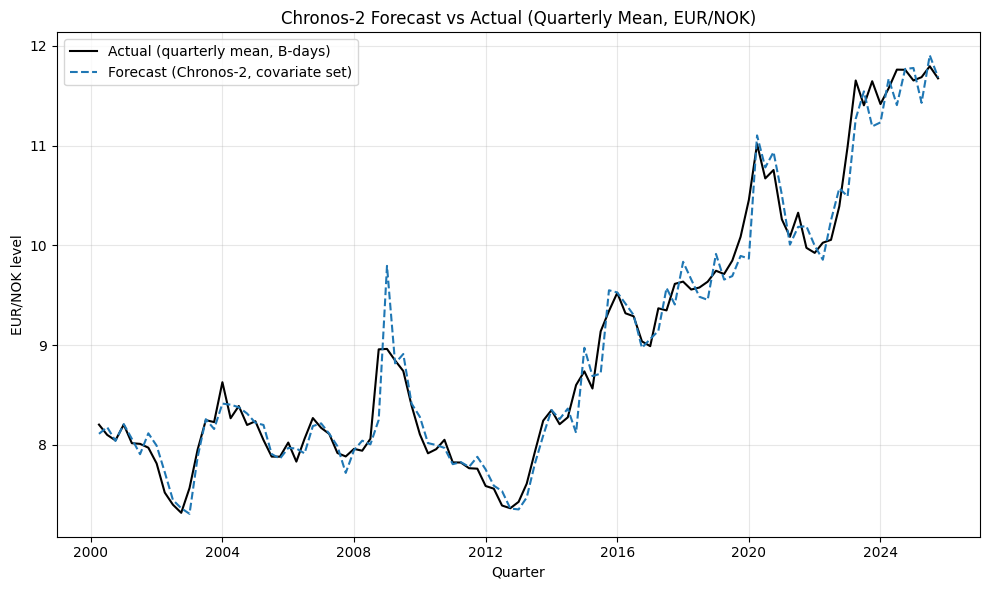

Saved: Chronos2Q_daily_importantcov.png
Saved: Chronos2Q_daily_importantcov.pdf


In [12]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - Covariates: quarterly-important covariates from round-1 LOO:
      IMPORTANT EXOG: VIX, SP500
      IMPORTANT MACRO: d_pi, Q
  - Cut: last business day of previous quarter (EUR_NOK B-days)
  - Forecast: next calendar quarter daily -> aggregated to quarterly B-day mean

Added:
  - Round-2 DM p-value importance via leave-one-out on the reduced important set.
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"      # calendar quarterly evaluation
    min_hist_days: int = 40    # minimum daily history before first forecast
    max_context: int = 2048
    max_horizon: int = 128     # safe cap > max quarter length (~92 days)
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_importantcov.png"
    fig_pdf: str = "Chronos2Q_daily_importantcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# IMPORTANT covariates from quarterly LOO (delta_p > 0)
IMPORTANT_EXOG_COLS = ["VIX", "SP500"]
IMPORTANT_MACRO_COLS = ["d_pi", "Q"]
ALL_COV_COLS = IMPORTANT_EXOG_COLS + IMPORTANT_MACRO_COLS


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retries."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill
      DF_d : daily (D) wide DataFrame with TARGET + IMPORTANT covariates (calendar days), ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(ALL_COV_COLS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar days) with forward fill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Find the last business-day timestamp in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Build SINGLE-SERIES context_df with past covariates (PARAMETRIC)
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <cov_cols>]
    Single item only (EUR_NOK). Covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")


# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create Chronos-2 forecasting function that uses past-only covariates."""

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """
        Forecast H days ahead using past-only covariates in context_df.
        future_df is NOT passed => covariates are treated as past-only.
        """
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # disable cross-learning explicitly
            )
        return _extract_median(pred)

    return _forecast


# -----------------------------
# Walk-forward (quarterly, past-only covariates)
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    """
    For each quarter:
      1) Cut history at last business day of previous quarter
      2) Forecast daily for next quarter (calendar days)
      3) Aggregate forecast to quarterly mean over business days
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        # Build context with *this* covariate set
        context_df = make_pastcov_context(hist_wide, cov_cols)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df


# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    """Compute RMSE/MAE and directional accuracy for quarterly means."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (quarterly mean, EUR/NOK – covariate set) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    """Standard normal CDF via erf."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test for equal predictive accuracy vs RW."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Random walk benchmark uses previous quarter's observed level."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot quarterly actual vs forecast and save."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, covariate set)")

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Leave-one-out DM p-value importance (round 2)
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
    silent_eval: bool = True,
) -> Tuple[float, float]:
    """Run quarterly walk-forward for a covariate set and return DM stat + p-value."""
    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn, cov_cols)
    ev = evaluate(df_eval, silent=silent_eval)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val


def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """
    Leave-one-out importance on quarterly evaluation:
      - Baseline DM p-value with cov_cols
      - Remove each covariate one at a time and recompute DM p-value
      - delta_p = p_without - p_baseline
    """
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, cov_cols)

    rows = []
    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, reduced)

        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,
            "dm_without": stat_i,
        })

    out = (
        pd.DataFrame(rows)
        .sort_values("delta_p", ascending=False)
        .reset_index(drop=True)
    )
    return base_stat, base_p, out


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Important covariates (round 1): {ALL_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    # Baseline on current important covariates
    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn, ALL_COV_COLS)
    eval_df = evaluate(df_eval, silent=False)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # Round-2 LOO on the reduced important set
    base_stat2, base_p2, loo_round2 = pvalue_importance_leave_one_out(
        S_b, DF_d, forecast_fn, ALL_COV_COLS
    )

    print("\n=== DM p-value importance (leave-one-out, quarterly | round 2 on important set) ===")
    print(f"Baseline DM-stat: {base_stat2:.4f} | p={base_p2:.4f}\n")
    print(loo_round2.to_string(index=False))

    next_covs = loo_round2.loc[loo_round2["delta_p"] > 0, "covariate"].tolist()
    print(f"\nSuggested important covariates (round 2, delta_p>0): {next_covs}")

    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()


Important covariates (round 3): ['VIX', 'SP500', 'Q']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['Q', 'SP500', 'EUR_NOK', 'VIX']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – covariate set) ===
Observations: 103
RMSE (level): 0.200701
MAE  (level): 0.143265
Directional accuracy: 78/102 (76.5%)

=== Diebold–Mariano vs Random Walk (quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -1.6473
p-value     : 0.0995

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== DM p-value importance (leave-one-out, quarterly | round 3) ===
Baseline DM-stat: -1.6473 | p=0.0995

covariate  p_without  delta_p  dm_without
      VIX   0.267806 0.168301   -1.108129
    SP500   

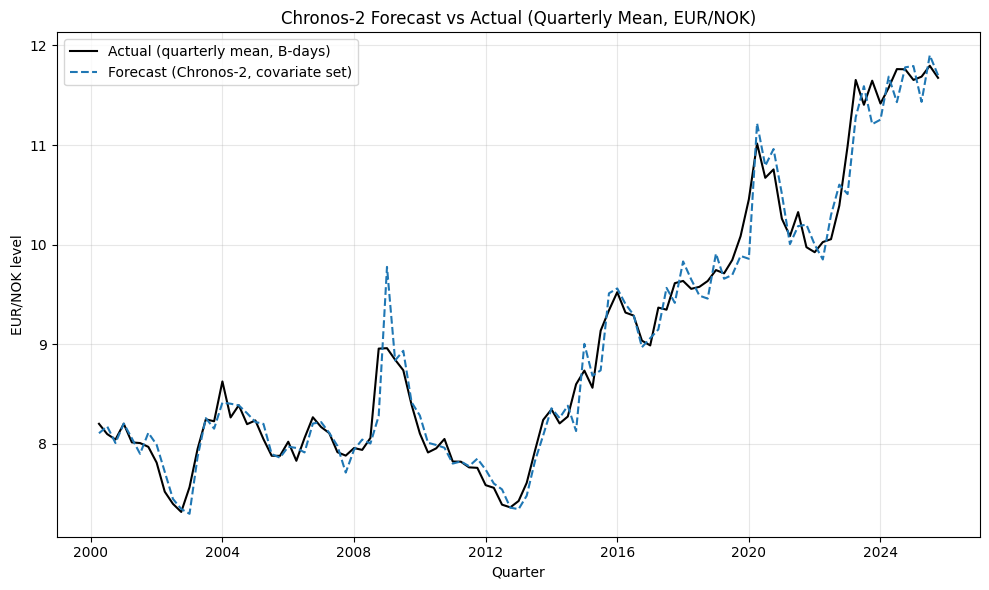

Saved: Chronos2Q_daily_round3.png
Saved: Chronos2Q_daily_round3.pdf


In [13]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with daily exogenous covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - Covariates: round-3 important set from round-2 LOO:
      IMPORTANT: VIX, SP500, Q
  - Cut: last business day of previous quarter (EUR_NOK B-days)
  - Forecast: next calendar quarter daily -> aggregated to quarterly B-day mean

Added:
  - Round-3 DM p-value importance via leave-one-out on the round-3 set.
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_round3.png"
    fig_pdf: str = "Chronos2Q_daily_round3.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# ROUND 3 important covariates (from round-2 LOO)
ROUND3_COV_COLS = ["VIX", "SP500", "Q"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retries."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str, cov_cols: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill
      DF_d : daily (D) wide DataFrame with TARGET + cov_cols (calendar days), ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(cov_cols)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK series
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DataFrame (calendar days) with forward fill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Find the last business-day timestamp in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Build context_df with past covariates (parametric)
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <cov_cols>]
    Single item only (EUR_NOK). Covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")


# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create Chronos-2 forecasting function that uses past-only covariates."""

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """Forecast H days ahead using past-only covariates in context_df."""
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,
            )
        return _extract_median(pred)

    return _forecast


# -----------------------------
# Quarterly walk-forward
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    """
    For each quarter:
      1) Cut history at last business day of previous quarter
      2) Forecast daily for next quarter (calendar days)
      3) Aggregate forecast to quarterly mean over business days
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide, cov_cols)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df


# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    """Compute RMSE/MAE and directional accuracy for quarterly means."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (quarterly mean, EUR/NOK – covariate set) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    """Standard normal CDF via erf."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test for equal predictive accuracy vs RW."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Random walk benchmark uses previous quarter's observed level."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot quarterly actual vs forecast and save."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, covariate set)")

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Leave-one-out DM p-value importance (round 3)
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
    silent_eval: bool = True,
) -> Tuple[float, float]:
    """Run quarterly walk-forward for a covariate set and return DM stat + p-value."""
    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn, cov_cols)
    ev = evaluate(df_eval, silent=silent_eval)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val


def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """
    Leave-one-out importance on quarterly evaluation:
      - Baseline DM p-value with cov_cols
      - Remove each covariate one at a time and recompute DM p-value
      - delta_p = p_without - p_baseline
    """
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, cov_cols)

    rows = []
    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, forecast_fn, reduced)

        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,
            "dm_without": stat_i,
        })

    out = (
        pd.DataFrame(rows)
        .sort_values("delta_p", ascending=False)
        .reset_index(drop=True)
    )
    return base_stat, base_p, out


# -----------------------------
# Main
# -----------------------------
def main():
    # Load data for round 3 covariates
    S_b, DF_d = load_series(CFG.url, ROUND3_COV_COLS)
    if CFG.verbose:
        print(f"Important covariates (round 3): {ROUND3_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    # Baseline on round-3 set
    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn, ROUND3_COV_COLS)
    eval_df = evaluate(df_eval, silent=False)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # LOO on round-3 set
    base_stat, base_p, loo_round3 = pvalue_importance_leave_one_out(
        S_b, DF_d, forecast_fn, ROUND3_COV_COLS
    )

    print("\n=== DM p-value importance (leave-one-out, quarterly | round 3) ===")
    print(f"Baseline DM-stat: {base_stat:.4f} | p={base_p:.4f}\n")
    print(loo_round3.to_string(index=False))

    next_covs = loo_round3.loc[loo_round3["delta_p"] > 0, "covariate"].tolist()
    print(f"\nSuggested important covariates (round 4, delta_p>0): {next_covs}")

    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()


Important covariates: ['VIX', 'SP500', 'Q']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['Q', 'SP500', 'EUR_NOK', 'VIX']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – important covariates) ===
Observations: 103
RMSE (level): 0.200701
MAE  (level): 0.143265
Directional accuracy: 78/102 (76.5%)

=== Diebold–Mariano vs Random Walk (important covariates, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -1.6473
p-value     : 0.0995


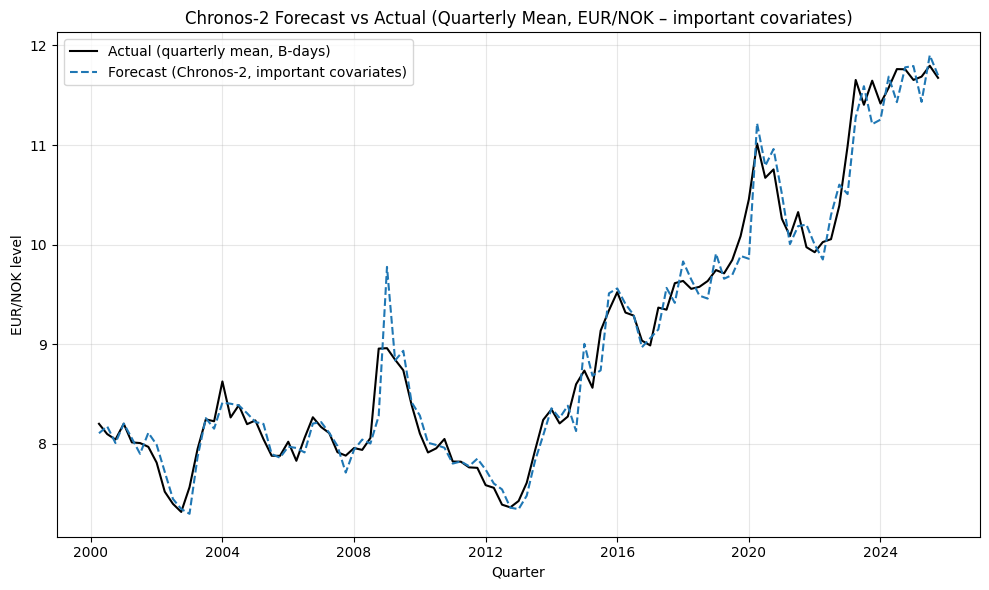

Saved: Chronos2Q_daily_finalcov.png
Saved: Chronos2Q_daily_finalcov.pdf


In [14]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with daily IMPORTANT covariates
Past-covariate setup (NO cross-learning):
  - Target: EUR_NOK daily (calendar D, ffill)
  - IMPORTANT covariates: VIX, SP500, Q (past-only in context_df)
  - Cut: last business day of previous quarter (EUR_NOK B-days)
  - Forecast: next calendar quarter daily -> aggregated to quarterly B-day mean
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_finalcov.png"
    fig_pdf: str = "Chronos2Q_daily_finalcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
IMPORTANT_COV_COLS = ["VIX", "SP500", "Q"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV as text with retries."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str, cov_cols: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with forward fill
      DF_d : daily (D) wide DataFrame with TARGET + cov_cols (calendar days), ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(cov_cols)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # numeric conversion
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # business-day EUR_NOK
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # daily wide with ffill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Find the last business-day timestamp in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Build context_df with past covariates
# -----------------------------
def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    """
    Output columns:
      ['item_id','timestamp','target', <cov_cols>]
    Single item only (EUR_NOK). Covariates are past-only.
    """
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET_SERIES,
        "target": hist_wide[TARGET_SERIES].astype(float).values,
    })

    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values

    return ctx.sort_values("timestamp")


# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """Create Chronos-2 forecasting function that uses past-only covariates."""

    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """Normalize Chronos output to (item_id, timestamp, y_pred)."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """Forecast H days ahead using past-only covariates in context_df."""
        with torch.inference_mode():
            pred = pipeline.predict_df(
                context_df,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,
            )
        return _extract_median(pred)

    return _forecast


# -----------------------------
# Quarterly walk-forward
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    """
    For each quarter:
      1) Cut history at last business day of previous quarter
      2) Forecast daily for next quarter (calendar days)
      3) Aggregate forecast to quarterly mean over business days
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_wide, cov_cols)

        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common_idx = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common_idx] = tmp.loc[common_idx]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df


# -----------------------------
# Evaluation / DM / Plot
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute RMSE/MAE and directional accuracy for quarterly means."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – important covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    """Standard normal CDF via erf."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """Diebold–Mariano test for equal predictive accuracy vs RW."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Random walk benchmark uses previous quarter's observed level."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (important covariates, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Plot quarterly actual vs forecast and save."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, important covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – important covariates)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url, IMPORTANT_COV_COLS)
    if CFG.verbose:
        print(f"Important covariates: {IMPORTANT_COV_COLS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn, IMPORTANT_COV_COLS)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)

    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()
